# Table of Content

<a name="outline"></a>

## Setup

- [A](#seca) External Imports
- [B](#secb) Internal Imports
- [C](#secd) Configurations and Paths 
- [D](#sece) Patient Interface and Train/Val/Test Partitioning


## Evaluations

- [1](#sec2) Predictive Performance: MIMIC-III (Test Set)
- [2](#sec3) Predictive Performance: MIMIC-IV (Test Set)
- [3](#sec4) Predictive Performance: from MIMIC-IV (Training Set) to MIMIC-III (All)

<a name="seca"></a>

### A External Imports [^](#outline)

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from IPython.display import display
from upsetplot import from_contents, plot, UpSet, from_indicators


<a name="secb"></a>

### B Internal Imports [^](#outline)

In [2]:
# HOME and DATA_STORE are arbitrary, change as appropriate.
HOME = os.environ.get('HOME')
DATA_STORE = f'{HOME}/GP/ehr-data'



%load_ext autoreload
%autoreload 2

import analysis as A
import common as C

/home/asem/GP/env/icenode-dev/lib/python3.8/site-packages/haiku/_src/data_structures.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


<a name="secc"></a>

### C Configurations and Paths [^](#outline)

In [3]:
with C.modified_environ(DATA_DIR=DATA_STORE):
    mimic3_dataset = C.datasets['M3']
    mimic4_dataset = C.datasets['M4']

                    Unrecognised <class 'icenode.ehr.coding_scheme.DxICD9'> codes (38)
                    to be removed: ['041.49', '282.40', '282.46', '284.11', '284.12', '284.19', '294.20', '294.21', '348.82', '365.70', '425.11', '425.18', '444.09', '512.83', '512.84', '512.89', '516.31', '516.34', '516.36', '518.51', '518.52', '518.53', '573.5', '596.89', '719.70', '747.32', '793.11', '793.19', '795.51', '997.49', '998.01', '998.09', '999.32', '999.33', 'V12.55', 'V13.89', 'V54.82', 'V88.21']
                    Unrecognised <class 'icenode.ehr.coding_scheme.PrICD9'> codes (7)
                    to be removed: ['02.21', '17.55', '17.56', '35.05', '36.01', '36.02', '36.05']
                    Unrecognised <class 'icenode.ehr.coding_scheme.DxICD10'> codes (4178)
                    to be removed: ['E10.3213', 'E10.3219', 'E10.3291', 'E10.3292', 'E10.3293', 'E10.3299', 'E10.3312', 'E10.3313', 'E10.3391', 'E10.3393', 'E10.3399', 'E10.3411', 'E10.3413', 'E10.3491', 'E10.3492', 'E10.35

                    Unrecognised <class 'icenode.ehr.coding_scheme.DxICD9'> codes (127)
                    to be removed: ['041.49', '173.01', '173.21', '173.22', '173.30', '173.31', '173.32', '173.39', '173.41', '173.42', '173.49', '173.50', '173.51', '173.52', '173.59', '173.60', '173.61', '173.62', '173.69', '173.71', '173.72', '173.79', '173.80', '173.81', '173.82', '173.91', '173.92', '173.99', '282.40', '282.43', '282.44', '282.46', '284.11', '284.12', '284.19', '286.52', '286.59', '294.20', '294.21', '310.81', '310.89', '331.6', '348.82', '358.30', '365.70', '365.71', '365.72', '365.73', '365.74', '379.27', '414.4', '415.13', '425.11', '425.18', '444.09', '488.81', '488.82', '488.89', '508.2', '512.2', '512.81', '512.82', '512.83', '512.84', '512.89', '516.31', '516.32', '516.33', '516.34', '516.36', '516.37', '516.5', '518.51', '518.52', '518.53', '539.01', '539.09', '539.89', '573.5', '596.81', '596.82', '596.83', '596.89', '629.31', '629.32', '631.0', '631.8', '649.81', '704

The following cell configures the location of the models pretrained on MIMIC-III (M3) and MIMIC-IV (M4), with GRAM embeddings (G) and without. Each training experiment produces 100 snapshots of parameters (100 training checkpoints throughout all the training iterations), and this Notebook picks the one that maximizes the average AUC of the visit level (prob. of having higher risks for present codes than the absent codes of the same visit).

In [4]:
train_dir = {
    # Location of training experiments on MIMIC-III.
    'M3': f'{DATA_STORE}/icd9v3/M3',
    # Location of training experiments on MIMIC-IV.
    'M4': f'{DATA_STORE}/icd9v3/M4'
}

In [5]:
relative_auc_config = {
    'pvalue': 0.01, 
    'min_auc': 0.9
}
top_k_list=[1, 2, 3, 5, 7, 10, 15, 20]
percentile_range=20 
n_percentiles=int(100/percentile_range)

import matplotlib.font_manager as font_manager
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'font.family': 'sans-serif',
                     'font.sans-serif': 'Helvetica',
                     'font.weight':  'normal'})

In [6]:
output_dir = 'artefacts'
Path(output_dir).mkdir(parents=True, exist_ok=True)


<a name="secd"></a>

### D Patient Interface and Train/Val/Test Patitioning [^](#outline)

In [7]:
code_scheme_M =  {
        "dx": "dx_icd9",
        "pr": "pr_icd9",
        "dx_outcome": "dx_icd9_filter_v3_groups",
        "pr": "pr_icd9"
}

code_scheme_G = {
        "dx": "dx_icd9",
        "pr": "pr_icd9",
        "dx_dagvec": True,
        "pr_dagvec": True,
        "dx_outcome": "dx_icd9_filter_v3_groups"
}

m3_interface_M = C.Subject_JAX.from_dataset(mimic3_dataset, code_scheme=code_scheme_M)
m4_interface_M = C.Subject_JAX.from_dataset(mimic4_dataset, code_scheme=code_scheme_M)

m3_interface_G = C.Subject_JAX.from_dataset(mimic3_dataset, code_scheme=code_scheme_G)
m4_interface_G = C.Subject_JAX.from_dataset(mimic4_dataset, code_scheme=code_scheme_G)

                            dx_icd10->dx_icd9 Unrecognised t_codes
                            (169):
                            ['041.41', '041.42', '041.43', '041.49', '173.00', '173.01', '173.02', '173.09', '173.10', '173.11', '173.12', '173.19', '173.20', '173.21', '173.22', '173.29', '173.30', '173.31', '173.32', '173.39']...
                            dx_icd10->dx_icd9 Unrecognised s_codes
                            (49910):
                            ['E08.3211', 'E08.3212', 'E08.3213', 'E08.3219', 'E08.3291', 'E08.3292', 'E08.3293', 'E08.3299', 'E08.3311', 'E08.3312', 'E08.3313', 'E08.3319', 'E08.3391', 'E08.3392', 'E08.3393', 'E08.3399', 'E08.3411', 'E08.3412', 'E08.3413', 'E08.3419']...
                            dx_icd10->dx_icd9 Unrecognised t_codes
                            (169):
                            ['041.41', '041.42', '041.43', '041.49', '173.00', '173.01', '173.02', '173.09', '173.10', '173.11', '173.12', '173.19', '173.20', '173.21', '173.22', '173.29',

In [8]:
m4_splits = m4_interface_M.random_splits(split1=0.7, split2=0.85, random_seed=42)
m3_splits = m3_interface_M.random_splits(split1=0.7, split2=0.85, random_seed=42)

In [9]:
m3_train_ids, m3_valid_ids, m3_test_ids = m3_splits
m4_train_ids, m4_valid_ids, m4_test_ids = m4_splits


In [10]:
m3_percentiles = m3_interface_M.dx_outcome_by_percentiles(20, m3_splits[0])
m4_percentiles = m4_interface_M.dx_outcome_by_percentiles(20, m4_splits[0])

<a name="sec1"></a>

## 1 Snooping/Selecting Best Models from the Validation Set [^](#outline)

In [11]:
from glob import glob
clfs = [os.path.basename(d) for d in glob(f"{train_dir['M3']}/*")]
model_dir = dict(zip(clfs, clfs))

In [12]:
print('> Models trained on MIMIC-III')
m3_top = A.get_trained_models(clfs=clfs, train_dir=train_dir, model_dir=model_dir, data_tag='M3', 
                               criterion='MICRO-AUC',  comp=max)
display(m3_top['summary'])

print('> Models trained on MIMIC-IV')
m4_top = A.get_trained_models(clfs=clfs, train_dir=train_dir, model_dir=model_dir, data_tag='M4', 
                               criterion='MICRO-AUC',  comp=max)
display(m4_top['summary'])

> Models trained on MIMIC-III


,Clf,Best_i,MICRO-AUC
0,dx_icenode_M,97,0.983421
1,dxpr_icenode_M,97,0.983421
2,dxpr_icenode_G,84,0.984158
3,dx_icenode_G,60,0.984230
4,dx_retain,18,0.984666
5,dx_gru_G,28,0.984298
6,dx_gru_M,11,0.984125


> Models trained on MIMIC-IV


/home/asem/GP/env/icenode-dev/lib/python3.8/site-packages/haiku/_src/data_structures.py:144: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, treedef = jax.tree_flatten(tree)
/home/asem/GP/env/icenode-dev/lib/python3.8/site-packages/haiku/_src/data_structures.py:145: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, leaves)


,Clf,Best_i,MICRO-AUC
0,dx_icenode_M,29,0.988557
1,dxpr_icenode_M,29,0.988546
2,dxpr_icenode_G,3,0.985475
3,dx_icenode_G,7,0.986985
4,dx_retain,12,0.988272
5,dx_gru_G,15,0.988389
6,dx_gru_M,11,0.987864


In [13]:
m3_interface = {'M': m3_interface_M, 'G': m3_interface_G}
m3_models = C.lsr_get_models(clfs, m3_top["config"], m3_top["params"], m3_interface)

m4_interface = {'M': m4_interface_M, 'G': m4_interface_G}
m4_models = C.lsr_get_models(clfs, m4_top["config"], m4_top["params"], m4_interface)


In [14]:

def cross_predictor(clf, source_tag, target_tag):
    _params = {'M3': m3_top['params'][clf], 
               'M4': m4_top['params'][clf]}
    _config = {'M3': m3_top['config'][clf], 
               'M4': m4_top['config'][clf]}
    _interface = {'M3': m3_interface, 'M4': m4_interface}
    _emb = 'G' if '_G' in clf else 'M'

    return C.lsr_get_model(clf=clf, 
                           config=_config[source_tag], 
                           params=_params[source_tag],
                           interface = _interface[target_tag][_emb])


<a name="sec2"></a>

## 2 Predictive Performance on MIMIC-III (Test Set) [^](#outline)

In [15]:
m3_predictors = {clf: cross_predictor(clf, 'M3', 'M3') for clf in clfs}

In [16]:
test_res_m3 = {clf: C.eval2_(model, m3_splits[2]) for clf, model in m3_predictors.items()} 

/home/asem/GP/env/icenode-dev/lib/python3.8/site-packages/haiku/_src/data_structures.py:144: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, treedef = jax.tree_flatten(tree)
/home/asem/GP/env/icenode-dev/lib/python3.8/site-packages/haiku/_src/data_structures.py:145: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, leaves)
/home/asem/GP/env/icenode-dev/lib/python3.8/site-packages/haiku/_src/data_structures.py:144: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, treedef = jax.tree_flatten(tree)
/home/asem/GP/env/icenode-dev/lib/python3.8/site-packages/haiku/_src/data_structures.py:145: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.t

In [26]:
auctests_m3 = A.codes_auc_pairwise_tests({k: v['risk_prediction'] for k, v in test_res_m3.items()}, fast=True)


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1842/2081 [00:13<00:04, 59.48it/s]WARNING:absl:Indeterminate test


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2081/2081 [00:18<00:00, 112.25it/s]


In [27]:
test_cols = [col for col in auctests_m3.columns if col[:2] == 'P0']
auctests_m3.loc[:, test_cols].isnull().max(axis=1).sum()

188

In [ ]:
# upset_clfs = ['ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN', 'LogReg', 
#               'ICE-NODE/G', 'ICE-NODE_UNIFORM/G', 'GRU/G']
m3_freq_v = m3_interface_M.dx_outcome_frequency_vec(m3_train_ids) 
m3_code_attrs = {'Code frequency': dict(zip(range(len(m3_freq_v)), m3_freq_v))}

m3_upset_result = A.relative_performance_upset(auctests_m3, clfs, 
                                               code_attrs=m3_code_attrs,
                                               interface=m3_interface_M,
                                               **relative_auc_config)
upset_ctx = lambda : sns.plotting_context("paper", font_scale=1.5, rc={"font.family": "sans-serif", 
                                                                        'axes.labelsize': 'medium',
                                                                       'ytick.labelsize': 'medium'})



with sns.axes_style("darkgrid"), upset_ctx():
    upset_format = from_indicators(m3_upset_result['indicator_df'], data=m3_upset_result['data'])
    upset_object = UpSet(upset_format, subset_size='count', show_counts=True)
    upset_object.style_subsets(absent=['LogReg'], present=('ICE-NODE', 'GRU', 'RETAIN'),
                               facecolor="red",
                               edgecolor="red", linewidth=3)
    upset_object.add_catplot(value='Code frequency', kind="strip")
    
    g = upset_object.plot()
        
    current_figure = plt.gcf()
    w, h = 2.5, 3
    wi, hi = current_figure.get_size_inches()
    current_figure.set_size_inches(hi*(w/h), hi)
    current_figure.savefig(f"{output_dir}/upset_M3.pdf", bbox_inches='tight')
    plt.show()

In [36]:
results_m3_eval,_ = A.evaluation_table(test_res_m3, m3_percentiles, top_k_list=top_k_list)

In [37]:
# table_clfs = ('LogReg', 
#               'RETAIN',
#               'GRU',
#               'GRU/G',
#               'ICE-NODE_UNIFORM',
#               'ICE-NODE_UNIFORM/G',
#               'ICE-NODE', 
#               'ICE-NODE/G'
#               )
table_clfs = sorted(clfs)
results_m3_tables = A.top_k_tables(table_clfs, results_m3_eval, top_k_list=top_k_list,
                                   n_percentiles=n_percentiles, out_prefix=f'{output_dir}/M3')

,ACC-P0-k1,ACC-P1-k1,ACC-P2-k1,ACC-P3-k1,ACC-P4-k1
dx_gru_G,0.007,0.059,0.086,0.090,0.403
dx_gru_M,0.001,0.057,0.060,0.081,0.424
dx_icenode_G,0.000,0.018,0.038,0.098,0.438
dx_icenode_M,0.000,0.018,0.051,0.062,0.451
dx_retain,0.004,0.059,0.058,0.092,0.410
dxpr_icenode_G,0.000,0.017,0.044,0.087,0.450
dxpr_icenode_M,0.000,0.018,0.051,0.062,0.451


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k1} & {ACC-P1-k1} & {ACC-P2-k1} & {ACC-P3-k1} & {ACC-P4-k1} \\
\texttt{dx\_gru\_G} & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.007 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.059 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.086 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.090 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.403 \\
\texttt{dx\_gru\_M} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.001 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.057 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.060 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.081 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.424 \\
\texttt{dx\_icenode\_G} & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.000 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.018 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.038 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.098 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{0000

,ACC-P0-k2,ACC-P1-k2,ACC-P2-k2,ACC-P3-k2,ACC-P4-k2
dx_gru_G,0.014,0.106,0.170,0.233,0.589
dx_gru_M,0.004,0.104,0.143,0.247,0.615
dx_icenode_G,0.002,0.047,0.098,0.247,0.660
dx_icenode_M,0.001,0.062,0.125,0.259,0.646
dx_retain,0.011,0.095,0.133,0.236,0.618
dxpr_icenode_G,0.001,0.053,0.110,0.242,0.664
dxpr_icenode_M,0.001,0.062,0.125,0.259,0.646


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k2} & {ACC-P1-k2} & {ACC-P2-k2} & {ACC-P3-k2} & {ACC-P4-k2} \\
\texttt{dx\_gru\_G} & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.014 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.106 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.170 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.233 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.589 \\
\texttt{dx\_gru\_M} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.004 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.104 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.143 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.247 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.615 \\
\texttt{dx\_icenode\_G} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.002 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.047 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.098 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.247 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{0000

,ACC-P0-k3,ACC-P1-k3,ACC-P2-k3,ACC-P3-k3,ACC-P4-k3
dx_gru_G,0.017,0.150,0.253,0.347,0.707
dx_gru_M,0.009,0.142,0.222,0.339,0.734
dx_icenode_G,0.010,0.081,0.165,0.362,0.776
dx_icenode_M,0.006,0.087,0.199,0.386,0.771
dx_retain,0.016,0.142,0.218,0.334,0.741
dxpr_icenode_G,0.006,0.098,0.195,0.361,0.771
dxpr_icenode_M,0.006,0.087,0.199,0.386,0.771


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k3} & {ACC-P1-k3} & {ACC-P2-k3} & {ACC-P3-k3} & {ACC-P4-k3} \\
\texttt{dx\_gru\_G} & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.017 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.150 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.253 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.347 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.707 \\
\texttt{dx\_gru\_M} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.009 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.142 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.222 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.339 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.734 \\
\texttt{dx\_icenode\_G} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.010 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.081 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.165 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.362 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1

,ACC-P0-k5,ACC-P1-k5,ACC-P2-k5,ACC-P3-k5,ACC-P4-k5
dx_gru_G,0.036,0.222,0.354,0.532,0.845
dx_gru_M,0.014,0.212,0.337,0.527,0.878
dx_icenode_G,0.015,0.141,0.300,0.557,0.906
dx_icenode_M,0.019,0.136,0.330,0.573,0.887
dx_retain,0.026,0.216,0.352,0.509,0.867
dxpr_icenode_G,0.012,0.160,0.332,0.537,0.897
dxpr_icenode_M,0.019,0.136,0.330,0.573,0.887


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k5} & {ACC-P1-k5} & {ACC-P2-k5} & {ACC-P3-k5} & {ACC-P4-k5} \\
\texttt{dx\_gru\_G} & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.036 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.222 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.354 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.532 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.845 \\
\texttt{dx\_gru\_M} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.014 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.212 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.337 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.527 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.878 \\
\texttt{dx\_icenode\_G} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.015 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.141 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.300 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.557 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1

,ACC-P0-k7,ACC-P1-k7,ACC-P2-k7,ACC-P3-k7,ACC-P4-k7
dx_gru_G,0.055,0.286,0.447,0.662,0.912
dx_gru_M,0.025,0.288,0.438,0.653,0.920
dx_icenode_G,0.026,0.211,0.413,0.701,0.958
dx_icenode_M,0.026,0.205,0.436,0.710,0.940
dx_retain,0.037,0.306,0.464,0.628,0.922
dxpr_icenode_G,0.033,0.220,0.438,0.682,0.953
dxpr_icenode_M,0.026,0.205,0.436,0.710,0.940


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k7} & {ACC-P1-k7} & {ACC-P2-k7} & {ACC-P3-k7} & {ACC-P4-k7} \\
\texttt{dx\_gru\_G} & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.055 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.286 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.447 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.662 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.912 \\
\texttt{dx\_gru\_M} & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.025 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.288 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.438 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.653 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.920 \\
\texttt{dx\_icenode\_G} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.026 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.211 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.413 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.701 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1

,ACC-P0-k10,ACC-P1-k10,ACC-P2-k10,ACC-P3-k10,ACC-P4-k10
dx_gru_G,0.076,0.388,0.567,0.767,0.950
dx_gru_M,0.041,0.395,0.542,0.773,0.951
dx_icenode_G,0.045,0.314,0.551,0.836,0.984
dx_icenode_M,0.053,0.326,0.598,0.831,0.972
dx_retain,0.055,0.398,0.594,0.762,0.960
dxpr_icenode_G,0.050,0.314,0.582,0.796,0.973
dxpr_icenode_M,0.053,0.326,0.598,0.831,0.972


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k10} & {ACC-P1-k10} & {ACC-P2-k10} & {ACC-P3-k10} & {ACC-P4-k10} \\
\texttt{dx\_gru\_G} & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.076 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.388 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.567 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.767 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.950 \\
\texttt{dx\_gru\_M} & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.041 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.395 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.542 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.773 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.951 \\
\texttt{dx\_icenode\_G} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.045 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.314 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.551 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.836 & {\cellcolor[HTML]{276419}} \color[HTML]

,ACC-P0-k15,ACC-P1-k15,ACC-P2-k15,ACC-P3-k15,ACC-P4-k15
dx_gru_G,0.124,0.526,0.700,0.884,0.983
dx_gru_M,0.073,0.536,0.718,0.900,0.980
dx_icenode_G,0.076,0.477,0.743,0.931,0.993
dx_icenode_M,0.084,0.496,0.766,0.941,0.989
dx_retain,0.102,0.528,0.750,0.896,0.983
dxpr_icenode_G,0.087,0.467,0.751,0.910,0.991
dxpr_icenode_M,0.084,0.496,0.766,0.941,0.989


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k15} & {ACC-P1-k15} & {ACC-P2-k15} & {ACC-P3-k15} & {ACC-P4-k15} \\
\texttt{dx\_gru\_G} & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.124 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.526 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.700 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.884 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.983 \\
\texttt{dx\_gru\_M} & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.073 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.536 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.718 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.900 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.980 \\
\texttt{dx\_icenode\_G} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.076 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.477 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.743 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.931 & {\cellcolor[HTML]{276419}} \color[HTML]

,ACC-P0-k20,ACC-P1-k20,ACC-P2-k20,ACC-P3-k20,ACC-P4-k20
dx_gru_G,0.170,0.616,0.786,0.940,0.993
dx_gru_M,0.112,0.653,0.816,0.946,0.988
dx_icenode_G,0.110,0.593,0.846,0.976,0.998
dx_icenode_M,0.129,0.621,0.842,0.971,0.996
dx_retain,0.138,0.653,0.830,0.947,0.990
dxpr_icenode_G,0.120,0.595,0.841,0.975,0.997
dxpr_icenode_M,0.129,0.621,0.842,0.971,0.996


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k20} & {ACC-P1-k20} & {ACC-P2-k20} & {ACC-P3-k20} & {ACC-P4-k20} \\
\texttt{dx\_gru\_G} & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.170 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.616 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.786 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.940 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.993 \\
\texttt{dx\_gru\_M} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.112 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.653 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.816 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.946 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.988 \\
\texttt{dx\_icenode\_G} & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.110 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.593 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.846 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.976 & {\cellcolor[HTML]{276419}} \color[HTML]

In [30]:
competing_tests_df = auctests_m3[auctests_m3.CODE_INDEX.isin(m3_upset_result['indicator_df'][m3_upset_result['indicator_df']['LogReg']==False].index)]
competing_tests_df.loc[:, [col for col in competing_tests_df.columns if col[:2]=='P0']]

,P0(AUC_GRU==AUC_GRU/G),P0(AUC_GRU==AUC_ICE-NODE),P0(AUC_GRU==AUC_ICE-NODE/G),P0(AUC_GRU==AUC_ICE-NODE_UNIFORM),P0(AUC_GRU==AUC_ICE-NODE_UNIFORM/G),P0(AUC_GRU==AUC_LogReg),P0(AUC_GRU==AUC_RETAIN),P0(AUC_GRU/G==AUC_ICE-NODE),P0(AUC_GRU/G==AUC_ICE-NODE/G),P0(AUC_GRU/G==AUC_ICE-NODE_UNIFORM),...,P0(AUC_ICE-NODE/G==AUC_ICE-NODE_UNIFORM),P0(AUC_ICE-NODE/G==AUC_ICE-NODE_UNIFORM/G),P0(AUC_ICE-NODE/G==AUC_LogReg),P0(AUC_ICE-NODE/G==AUC_RETAIN),P0(AUC_ICE-NODE_UNIFORM==AUC_ICE-NODE_UNIFORM/G),P0(AUC_ICE-NODE_UNIFORM==AUC_LogReg),P0(AUC_ICE-NODE_UNIFORM==AUC_RETAIN),P0(AUC_ICE-NODE_UNIFORM/G==AUC_LogReg),P0(AUC_ICE-NODE_UNIFORM/G==AUC_RETAIN),P0(AUC_LogReg==AUC_RETAIN)
7,0.274,0.064,0.051,0.059,0.047,3.589e-02,0.588,0.022,0.015,0.015,...,0.348,0.678,8.898e-01,0.036,0.362,5.910e-01,0.040,8.469e-01,0.032,1.917e-02
129,0.407,0.161,0.417,0.193,0.238,4.051e-02,0.109,0.451,0.772,0.527,...,0.378,0.156,7.461e-03,0.713,0.992,6.013e-03,0.922,5.779e-03,0.919,1.175e-02
135,0.166,0.592,0.408,0.334,0.412,1.721e-07,0.601,0.840,0.892,0.874,...,0.995,0.821,8.183e-05,0.650,0.930,2.707e-05,0.592,6.315e-05,0.669,6.132e-07


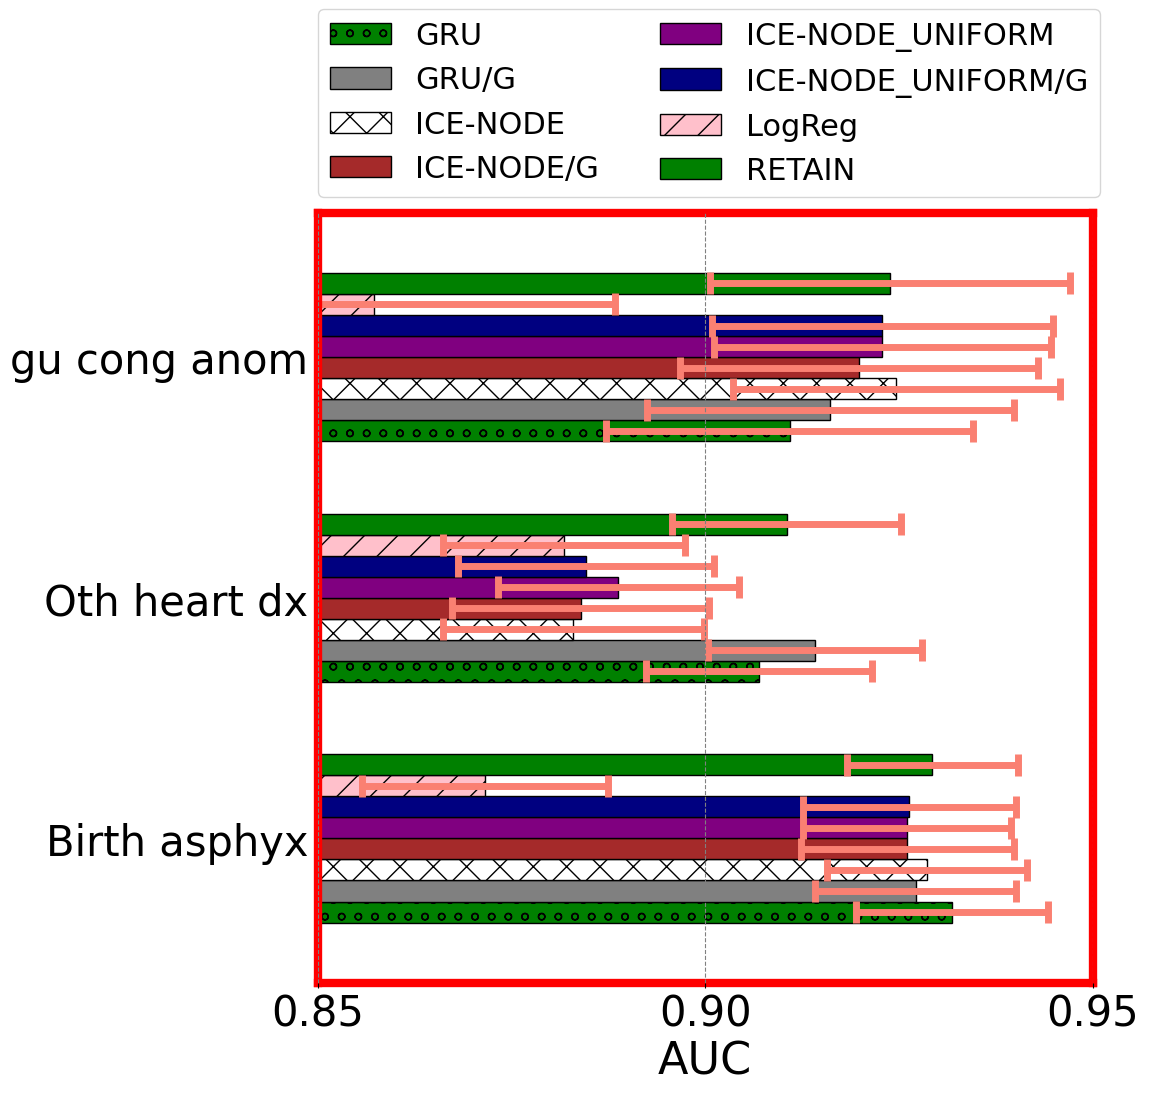

In [31]:
upset_clfs = ['ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN', 'LogReg',
              'ICE-NODE/G', 'ICE-NODE_UNIFORM/G', 'GRU/G']

ax = A.selected_auc_barplot(upset_clfs, competing_tests_df,  horizontal=True)
ax.legend(fontsize=22, title_fontsize=32,
          bbox_to_anchor=(-0.02, 1), ncol=2)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

current_figure = plt.gcf()
# w, h = 4, 4
# wi, hi = current_figure.get_size_inches()
# current_figure.set_size_inches(hi*(w/h), hi)

current_figure.savefig(f"{output_dir}/icenode_m3.pdf", bbox_inches='tight')
plt.show()


<a name="sec3"></a>

## 3 Relative AUC Performance on MIMIC-IV (Test Set) [^](#outline)

In [20]:
m4_predictors = {clf: cross_predictor(clf, 'M4', 'M4') for clf in clfs}

In [21]:
test_res_m4 = {clf: C.eval2_(model, m4_test_ids) for clf, model in m4_predictors.items()} 

/home/asem/GP/env/icenode-dev/lib/python3.8/site-packages/haiku/_src/data_structures.py:144: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, treedef = jax.tree_flatten(tree)
/home/asem/GP/env/icenode-dev/lib/python3.8/site-packages/haiku/_src/data_structures.py:145: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, leaves)
/home/asem/GP/env/icenode-dev/lib/python3.8/site-packages/haiku/_src/data_structures.py:144: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, treedef = jax.tree_flatten(tree)
/home/asem/GP/env/icenode-dev/lib/python3.8/site-packages/haiku/_src/data_structures.py:145: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.t

In [38]:
auctests_m4 = A.codes_auc_pairwise_tests({k: v['risk_prediction'] for k, v in test_res_m4.items()}, fast=True)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2081/2081 [25:57<00:00,  1.34it/s]


319 codes predicted an AUC higher than 0.9 by at least one model.
319 codes predicted an AUC higher than 0.9 by at least one model, with valid tests.


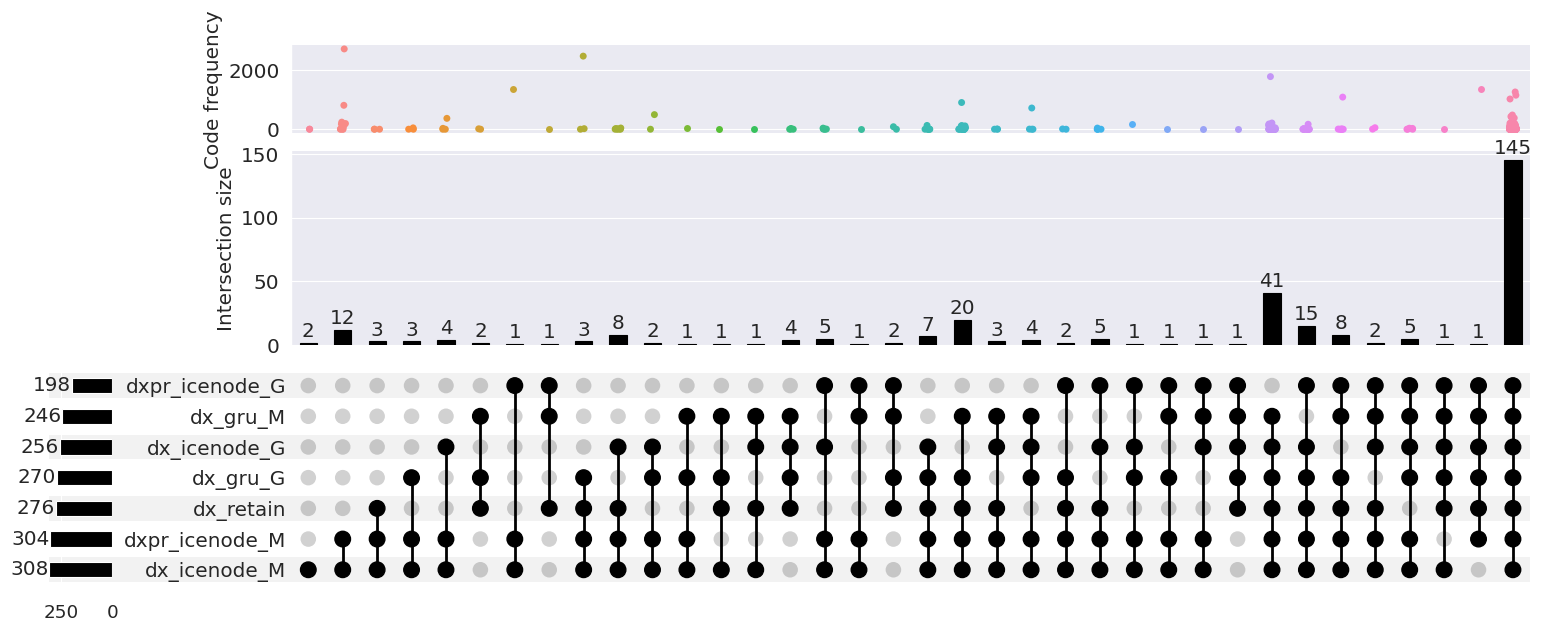

In [41]:
# upset_clfs = ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN', 'LogReg',)
#                'ICE-NODE/G', 'ICE-NODE_UNIFORM/G', 'GRU/G')

m4_freq_v = m4_interface_M.dx_outcome_frequency_vec(m4_train_ids) 
m4_code_attrs = {'Code frequency': dict(zip(range(len(m4_freq_v)), m4_freq_v))}

m4_upset_result = A.relative_performance_upset(auctests_m4, clfs, 
                                               code_attrs=m4_code_attrs,
                                               interface=m4_interface_M,
                                               **relative_auc_config)
upset_ctx = lambda : sns.plotting_context("paper",  font_scale=1.5, rc={"font.family": "Loma", 
                                                                        'axes.labelsize': 'medium',
                                                                       'ytick.labelsize': 'medium'})
with sns.axes_style("darkgrid"), upset_ctx():
    upset_format = from_indicators(m4_upset_result['indicator_df'], data=m4_upset_result['data'])
    upset_object = UpSet(upset_format, subset_size='count', show_counts=True)
#     upset_object.style_subsets(present=['ICE-NODE'], absent=('ICE-NODE_UNIFORM', 'GRU', 'RETAIN'),
#                                edgecolor="red", linewidth=3, facecolor="red")
    upset_object.add_catplot(value='Code frequency', kind="strip")

    g = upset_object.plot()
    current_figure = plt.gcf()
#     w, h = 5, 3
#     wi, hi = current_figure.get_size_inches()
#     current_figure.set_size_inches(hi*(w/h), hi)

    current_figure.savefig(f"{output_dir}/upset_M4.pdf", bbox_inches='tight')
    plt.show()


In [42]:
results_m4_eval, _ = A.evaluation_table(test_res_m4, m4_percentiles, top_k_list=top_k_list)

In [43]:
# table_clfs = ('LogReg', 
#               'RETAIN',
#               'GRU',
#               'GRU/G',
#               'ICE-NODE_UNIFORM',
#               'ICE-NODE_UNIFORM/G',
#               'ICE-NODE', 
#               'ICE-NODE/G',
#               )
table_clfs = sorted(clfs)
results_m4_tables = A.top_k_tables(table_clfs, results_m4_eval, top_k_list=top_k_list, 
                                   n_percentiles=n_percentiles, out_prefix=f'{output_dir}/M4')

,ACC-P0-k1,ACC-P1-k1,ACC-P2-k1,ACC-P3-k1,ACC-P4-k1
dx_gru_G,0.030,0.063,0.082,0.224,0.382
dx_gru_M,0.036,0.070,0.077,0.191,0.408
dx_icenode_G,0.008,0.035,0.068,0.169,0.461
dx_icenode_M,0.029,0.062,0.087,0.191,0.402
dx_retain,0.037,0.066,0.073,0.179,0.414
dxpr_icenode_G,0.005,0.032,0.044,0.187,0.456
dxpr_icenode_M,0.029,0.062,0.088,0.191,0.400


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k1} & {ACC-P1-k1} & {ACC-P2-k1} & {ACC-P3-k1} & {ACC-P4-k1} \\
\texttt{dx\_gru\_G} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.030 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.063 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.082 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.224 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.382 \\
\texttt{dx\_gru\_M} & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.036 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.070 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.077 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.191 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.408 \\
\texttt{dx\_icenode\_G} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.008 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.035 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.068 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.169 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1

,ACC-P0-k2,ACC-P1-k2,ACC-P2-k2,ACC-P3-k2,ACC-P4-k2
dx_gru_G,0.058,0.127,0.170,0.415,0.592
dx_gru_M,0.066,0.135,0.163,0.367,0.620
dx_icenode_G,0.018,0.091,0.157,0.356,0.649
dx_icenode_M,0.056,0.143,0.186,0.361,0.588
dx_retain,0.068,0.127,0.164,0.362,0.615
dxpr_icenode_G,0.012,0.077,0.119,0.380,0.653
dxpr_icenode_M,0.056,0.143,0.187,0.359,0.589


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k2} & {ACC-P1-k2} & {ACC-P2-k2} & {ACC-P3-k2} & {ACC-P4-k2} \\
\texttt{dx\_gru\_G} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.058 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.127 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.170 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.415 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.592 \\
\texttt{dx\_gru\_M} & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.066 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.135 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.163 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.367 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.620 \\
\texttt{dx\_icenode\_G} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.018 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.091 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.157 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.356 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{0000

,ACC-P0-k3,ACC-P1-k3,ACC-P2-k3,ACC-P3-k3,ACC-P4-k3
dx_gru_G,0.080,0.179,0.259,0.552,0.741
dx_gru_M,0.090,0.190,0.249,0.527,0.743
dx_icenode_G,0.033,0.136,0.246,0.510,0.761
dx_icenode_M,0.084,0.209,0.278,0.504,0.703
dx_retain,0.096,0.178,0.251,0.515,0.742
dxpr_icenode_G,0.023,0.114,0.200,0.532,0.780
dxpr_icenode_M,0.085,0.209,0.279,0.503,0.702


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k3} & {ACC-P1-k3} & {ACC-P2-k3} & {ACC-P3-k3} & {ACC-P4-k3} \\
\texttt{dx\_gru\_G} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.080 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.179 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.259 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.552 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.741 \\
\texttt{dx\_gru\_M} & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.090 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.190 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.249 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.527 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.743 \\
\texttt{dx\_icenode\_G} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.033 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.136 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.246 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.510 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{0000

,ACC-P0-k5,ACC-P1-k5,ACC-P2-k5,ACC-P3-k5,ACC-P4-k5
dx_gru_G,0.122,0.278,0.425,0.710,0.861
dx_gru_M,0.133,0.287,0.408,0.701,0.858
dx_icenode_G,0.062,0.223,0.412,0.677,0.862
dx_icenode_M,0.136,0.311,0.439,0.666,0.818
dx_retain,0.148,0.270,0.408,0.689,0.858
dxpr_icenode_G,0.042,0.187,0.364,0.690,0.886
dxpr_icenode_M,0.137,0.312,0.439,0.665,0.817


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k5} & {ACC-P1-k5} & {ACC-P2-k5} & {ACC-P3-k5} & {ACC-P4-k5} \\
\texttt{dx\_gru\_G} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.122 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.278 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.425 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.710 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.861 \\
\texttt{dx\_gru\_M} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.133 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.287 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.408 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.701 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.858 \\
\texttt{dx\_icenode\_G} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.062 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.223 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.412 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.677 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{0000

,ACC-P0-k7,ACC-P1-k7,ACC-P2-k7,ACC-P3-k7,ACC-P4-k7
dx_gru_G,0.156,0.366,0.551,0.799,0.909
dx_gru_M,0.170,0.370,0.528,0.796,0.908
dx_icenode_G,0.089,0.297,0.526,0.777,0.911
dx_icenode_M,0.177,0.387,0.552,0.766,0.879
dx_retain,0.186,0.347,0.530,0.789,0.914
dxpr_icenode_G,0.061,0.256,0.485,0.783,0.929
dxpr_icenode_M,0.177,0.388,0.551,0.765,0.878


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k7} & {ACC-P1-k7} & {ACC-P2-k7} & {ACC-P3-k7} & {ACC-P4-k7} \\
\texttt{dx\_gru\_G} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.156 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.366 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.551 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.799 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.909 \\
\texttt{dx\_gru\_M} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.170 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.370 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.528 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.796 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.908 \\
\texttt{dx\_icenode\_G} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.089 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.297 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.526 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.777 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{0000

,ACC-P0-k10,ACC-P1-k10,ACC-P2-k10,ACC-P3-k10,ACC-P4-k10
dx_gru_G,0.201,0.470,0.674,0.874,0.945
dx_gru_M,0.215,0.466,0.656,0.873,0.946
dx_icenode_G,0.127,0.394,0.645,0.862,0.950
dx_icenode_M,0.221,0.476,0.664,0.852,0.928
dx_retain,0.228,0.441,0.655,0.880,0.958
dxpr_icenode_G,0.092,0.350,0.620,0.870,0.963
dxpr_icenode_M,0.221,0.477,0.663,0.852,0.927


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k10} & {ACC-P1-k10} & {ACC-P2-k10} & {ACC-P3-k10} & {ACC-P4-k10} \\
\texttt{dx\_gru\_G} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.201 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.470 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.674 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.874 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.945 \\
\texttt{dx\_gru\_M} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.215 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.466 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.656 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.873 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.946 \\
\texttt{dx\_icenode\_G} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.127 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.394 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.645 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.862 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]

,ACC-P0-k15,ACC-P1-k15,ACC-P2-k15,ACC-P3-k15,ACC-P4-k15
dx_gru_G,0.258,0.585,0.795,0.934,0.971
dx_gru_M,0.271,0.587,0.782,0.933,0.975
dx_icenode_G,0.177,0.520,0.776,0.931,0.977
dx_icenode_M,0.280,0.578,0.784,0.924,0.967
dx_retain,0.279,0.566,0.787,0.947,0.985
dxpr_icenode_G,0.135,0.488,0.760,0.940,0.986
dxpr_icenode_M,0.281,0.578,0.783,0.924,0.967


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k15} & {ACC-P1-k15} & {ACC-P2-k15} & {ACC-P3-k15} & {ACC-P4-k15} \\
\texttt{dx\_gru\_G} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.258 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.585 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.795 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.934 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.971 \\
\texttt{dx\_gru\_M} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.271 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.587 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.782 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.933 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.975 \\
\texttt{dx\_icenode\_G} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.177 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.520 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.776 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.931 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]

,ACC-P0-k20,ACC-P1-k20,ACC-P2-k20,ACC-P3-k20,ACC-P4-k20
dx_gru_G,0.308,0.671,0.862,0.958,0.985
dx_gru_M,0.317,0.673,0.849,0.958,0.985
dx_icenode_G,0.222,0.618,0.854,0.961,0.989
dx_icenode_M,0.326,0.659,0.853,0.958,0.982
dx_retain,0.322,0.655,0.861,0.971,0.992
dxpr_icenode_G,0.176,0.595,0.845,0.967,0.992
dxpr_icenode_M,0.326,0.660,0.851,0.957,0.982


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k20} & {ACC-P1-k20} & {ACC-P2-k20} & {ACC-P3-k20} & {ACC-P4-k20} \\
\texttt{dx\_gru\_G} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.308 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.671 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.862 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.958 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.985 \\
\texttt{dx\_gru\_M} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.317 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.673 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.849 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.958 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.985 \\
\texttt{dx\_icenode\_G} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.222 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.618 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.854 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.961 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]

In [38]:
icenode_m4_excl = m4_upset_result['content_sets']['ICE-NODE'] - set.union(*list(m4_upset_result['content_sets'][clf] for clf in ('RETAIN', 'GRU', 'ICE-NODE_UNIFORM')))
icenode_m4_excl = m4_upset_result['competing_performance'][m4_upset_result['competing_performance']['CODE_INDEX'].isin(icenode_m4_excl)]
icenode_m4_excl

,CODE_INDEX,N_POSITIVE_CODES,AUC(GRU),AUC(GRU/G),AUC(ICE-NODE),AUC(ICE-NODE/G),AUC(ICE-NODE_UNIFORM),AUC(ICE-NODE_UNIFORM/G),AUC(LogReg),AUC(RETAIN),...,P0(AUC_ICE-NODE/G==AUC_ICE-NODE_UNIFORM/G),P0(AUC_ICE-NODE/G==AUC_LogReg),P0(AUC_ICE-NODE/G==AUC_RETAIN),P0(AUC_ICE-NODE_UNIFORM==AUC_ICE-NODE_UNIFORM/G),P0(AUC_ICE-NODE_UNIFORM==AUC_LogReg),P0(AUC_ICE-NODE_UNIFORM==AUC_RETAIN),P0(AUC_ICE-NODE_UNIFORM/G==AUC_LogReg),P0(AUC_ICE-NODE_UNIFORM/G==AUC_RETAIN),P0(AUC_LogReg==AUC_RETAIN),DESC
6,6,2063.0,0.899,0.901,0.917,0.915,0.892,0.892,0.892,0.899,...,5.134e-24,9.131e-15,2.729e-09,0.794,9.974e-01,8.068e-05,9.344e-01,9.193e-05,7.969e-05,Pulm hart dx
94,94,129.0,0.959,0.960,0.969,0.971,0.960,0.959,0.926,0.961,...,7.252e-05,8.035e-11,2.701e-03,0.446,2.419e-07,4.685e-01,4.620e-07,2.815e-01,3.944e-09,Early labor
105,105,1040.0,0.981,0.981,0.984,0.985,0.979,0.979,0.970,0.980,...,2.064e-12,1.412e-25,9.216e-11,0.370,3.887e-09,2.257e-01,4.003e-10,3.306e-01,1.512e-15,Forceps del
236,236,8394.0,0.888,0.881,0.912,0.913,0.886,0.885,0.870,0.890,...,1.172e-92,3.731e-99,2.282e-45,0.026,1.358e-17,1.826e-03,4.539e-16,1.793e-04,3.536e-36,Other ear dx


In [39]:
# icenode_ratain_gru_m4 = upsetcontents_m4['ICE-NODE']
# icenode_ratain_gru_m4 = compete_codesm4[compete_codesm4['CODE_INDEX'].isin(icenode_ratain_gru_m4)]
# icenode_ratain_gru_m4.sort_values('AUC(ICE-NODE)', ascending=False)[['CODE_INDEX', 'N_POSITIVE_CODES', 'DESC', 'AUC(ICE-NODE)']]

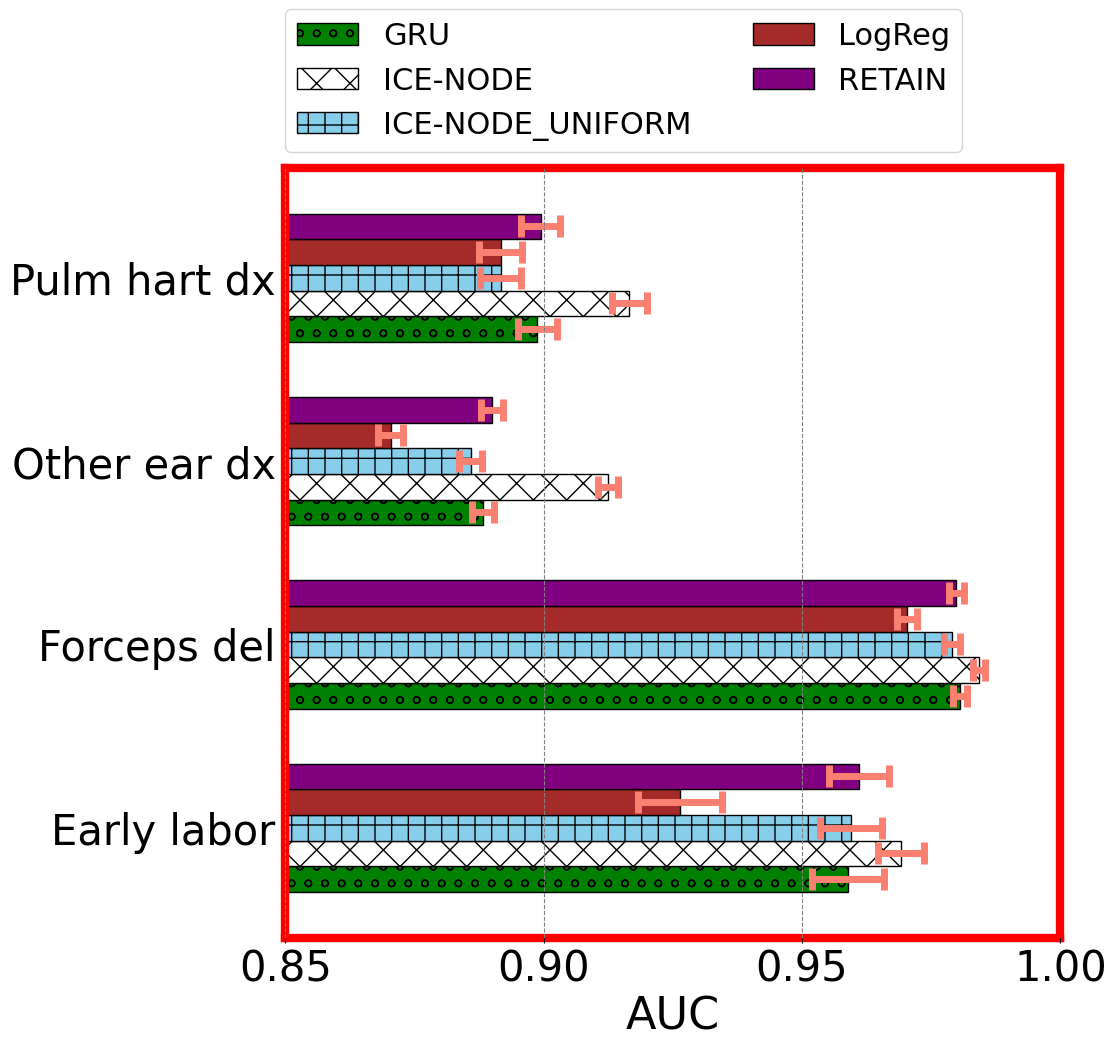

In [40]:
upset_clfs = ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN', 'LogReg')
w, h = 4, 3
ax = A.selected_auc_barplot(upset_clfs, icenode_m4_excl, horizontal=True)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
ax.legend(fontsize=22, title_fontsize=32,
          bbox_to_anchor=(-0.02, 1), ncol=2)
current_figure = plt.gcf()
w, h = 4, 4
wi, hi = current_figure.get_size_inches()
current_figure.set_size_inches(hi*(w/h), hi)

current_figure.savefig(f"{output_dir}/icenode_m4.pdf", bbox_inches='tight')
plt.show()


<a name="sec4"></a>

## 4 Relative AUC Performance From MIMIC-IV (Training Set) to MIMIC-III (All) [^](#outline)

In [44]:
# clfs_ordered = ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN')
m3_subjects = list(m3_interface_M.subjects.keys())
m4m3_predictors = {clf: cross_predictor(clf, 'M4', 'M3') for clf in clfs}

In [23]:
test_res_m4m3 = {clf: C.eval2_(model, m3_subjects) for clf, model in m4m3_predictors.items()} 

/home/asem/GP/env/icenode-dev/lib/python3.8/site-packages/haiku/_src/data_structures.py:144: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, treedef = jax.tree_flatten(tree)
/home/asem/GP/env/icenode-dev/lib/python3.8/site-packages/haiku/_src/data_structures.py:145: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, leaves)
/home/asem/GP/env/icenode-dev/lib/python3.8/site-packages/haiku/_src/data_structures.py:144: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, treedef = jax.tree_flatten(tree)
/home/asem/GP/env/icenode-dev/lib/python3.8/site-packages/haiku/_src/data_structures.py:145: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.t

In [39]:
auctests_m4m3 = A.codes_auc_pairwise_tests({k: v['risk_prediction'] for k, v in test_res_m4m3.items()}, fast=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2081/2081 [03:43<00:00,  9.32it/s]


171 codes predicted an AUC higher than 0.9 by at least one model.
160 codes predicted an AUC higher than 0.9 by at least one model, with valid tests.


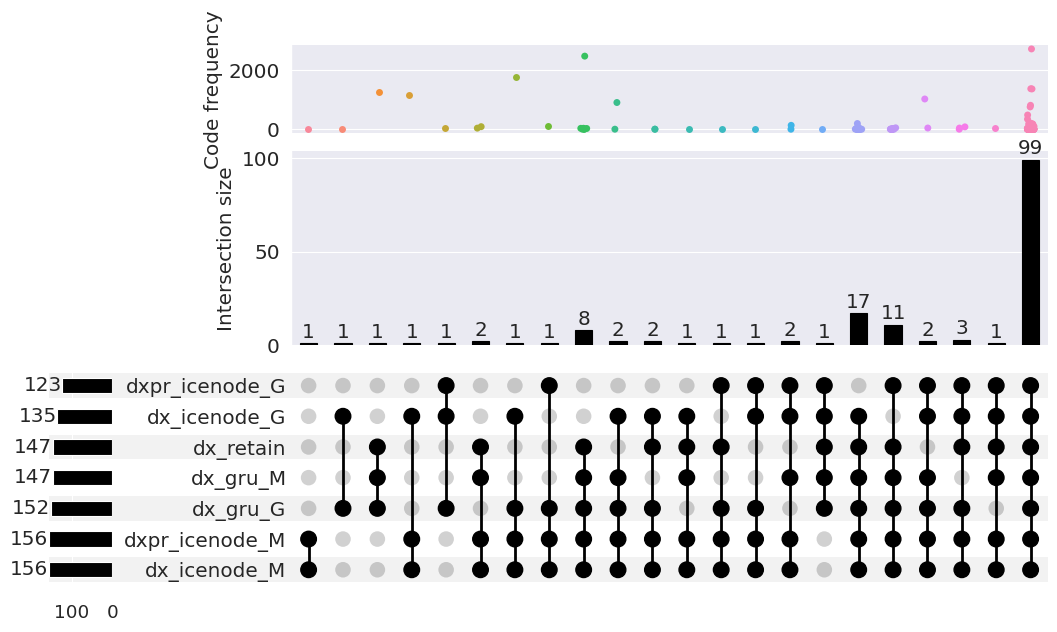

In [47]:
# upset_clfs = ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN', 'LogReg',)
#                 'ICE-NODE/G', 'ICE-NODE_UNIFORM/G', 'GRU/G')

m4m3_freq_v = m4_interface_M.dx_outcome_frequency_vec(m4_train_ids) 
m4m3_code_attrs = {'Code frequency': dict(zip(range(len(m4_freq_v)), m4_freq_v))}

m4m3_upset_result = A.relative_performance_upset(auctests_m4m3, clfs, 
                                                 code_attrs=m4m3_code_attrs,
                                                 interface=m3_interface_M,
                                                 **relative_auc_config)

upset_ctx = lambda : sns.plotting_context("paper", font_scale=1.5, rc={"font.family": "Loma", 
                                                                        'axes.labelsize': 'medium',
                                                                       'ytick.labelsize': 'medium'})
with sns.axes_style("darkgrid"), upset_ctx():
    upset_format = from_indicators(m4m3_upset_result['indicator_df'], data=m4m3_upset_result['data'])
    upset_object = UpSet(upset_format, subset_size='count', show_counts=True)
    upset_object.add_catplot(value='Code frequency', kind="strip")

#     upset_object.style_subsets(present='ICE-NODE', absent=['ICE-NODE_UNIFORM', 'GRU', 'RETAIN'],
#                               edgecolor="red", facecolor="red")
    g = upset_object.plot()
    
    current_figure = plt.gcf()
    current_figure.savefig(f"{output_dir}/upset_M4M3.pdf", bbox_inches='tight')
    plt.show()

In [49]:
results_m4m3_eval, _ = A.evaluation_table(test_res_m4m3, m4_percentiles, top_k_list=top_k_list)

In [50]:
# table_clfs = ('LogReg', 
#               'RETAIN',
#               'GRU',
#               'GRU/G',
#               'ICE-NODE', 
#               'ICE-NODE/G',
#               'ICE-NODE_UNIFORM',
#               'ICE-NODE_UNIFORM/G'
#               )
table_clfs = sorted(clfs)
results_m4m3_tables = A.top_k_tables(table_clfs, results_m4m3_eval, top_k_list=top_k_list, 
                                     n_percentiles=n_percentiles, out_prefix=f'{output_dir}/M4M3')

,ACC-P0-k1,ACC-P1-k1,ACC-P2-k1,ACC-P3-k1,ACC-P4-k1
dx_gru_G,0.022,0.058,0.083,0.210,0.323
dx_gru_M,0.029,0.069,0.086,0.206,0.312
dx_icenode_G,0.003,0.028,0.069,0.148,0.409
dx_icenode_M,0.022,0.046,0.087,0.203,0.335
dx_retain,0.035,0.060,0.074,0.187,0.328
dxpr_icenode_G,0.001,0.023,0.057,0.149,0.409
dxpr_icenode_M,0.023,0.047,0.088,0.202,0.335


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k1} & {ACC-P1-k1} & {ACC-P2-k1} & {ACC-P3-k1} & {ACC-P4-k1} \\
\texttt{dx\_gru\_G} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.022 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.058 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.083 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.210 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.323 \\
\texttt{dx\_gru\_M} & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.029 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.069 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.086 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.206 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.312 \\
\texttt{dx\_icenode\_G} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.003 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.028 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.069 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.148 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{0000

,ACC-P0-k2,ACC-P1-k2,ACC-P2-k2,ACC-P3-k2,ACC-P4-k2
dx_gru_G,0.039,0.114,0.168,0.360,0.560
dx_gru_M,0.050,0.125,0.172,0.348,0.534
dx_icenode_G,0.008,0.081,0.144,0.322,0.609
dx_icenode_M,0.038,0.122,0.171,0.329,0.538
dx_retain,0.059,0.120,0.155,0.328,0.545
dxpr_icenode_G,0.005,0.060,0.120,0.332,0.616
dxpr_icenode_M,0.039,0.122,0.172,0.327,0.537


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k2} & {ACC-P1-k2} & {ACC-P2-k2} & {ACC-P3-k2} & {ACC-P4-k2} \\
\texttt{dx\_gru\_G} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.039 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.114 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.168 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.360 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.560 \\
\texttt{dx\_gru\_M} & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.050 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.125 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.172 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.348 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.534 \\
\texttt{dx\_icenode\_G} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.008 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.081 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.144 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.322 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{0000

,ACC-P0-k3,ACC-P1-k3,ACC-P2-k3,ACC-P3-k3,ACC-P4-k3
dx_gru_G,0.054,0.160,0.256,0.451,0.708
dx_gru_M,0.063,0.169,0.260,0.455,0.678
dx_icenode_G,0.016,0.124,0.226,0.436,0.727
dx_icenode_M,0.057,0.172,0.255,0.426,0.668
dx_retain,0.082,0.169,0.245,0.424,0.689
dxpr_icenode_G,0.009,0.092,0.199,0.436,0.747
dxpr_icenode_M,0.058,0.173,0.254,0.424,0.667


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k3} & {ACC-P1-k3} & {ACC-P2-k3} & {ACC-P3-k3} & {ACC-P4-k3} \\
\texttt{dx\_gru\_G} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.054 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.160 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.256 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.451 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.708 \\
\texttt{dx\_gru\_M} & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.063 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.169 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.260 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.455 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.678 \\
\texttt{dx\_icenode\_G} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.016 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.124 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.226 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.436 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{0000

,ACC-P0-k5,ACC-P1-k5,ACC-P2-k5,ACC-P3-k5,ACC-P4-k5
dx_gru_G,0.083,0.245,0.407,0.604,0.842
dx_gru_M,0.094,0.248,0.399,0.615,0.832
dx_icenode_G,0.035,0.185,0.365,0.595,0.846
dx_icenode_M,0.095,0.250,0.396,0.567,0.803
dx_retain,0.115,0.253,0.390,0.572,0.833
dxpr_icenode_G,0.018,0.149,0.342,0.588,0.869
dxpr_icenode_M,0.096,0.250,0.396,0.563,0.803


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k5} & {ACC-P1-k5} & {ACC-P2-k5} & {ACC-P3-k5} & {ACC-P4-k5} \\
\texttt{dx\_gru\_G} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.083 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.245 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.407 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.604 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.842 \\
\texttt{dx\_gru\_M} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.094 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.248 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.399 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.615 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.832 \\
\texttt{dx\_icenode\_G} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.035 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.185 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.365 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.595 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{0000

,ACC-P0-k7,ACC-P1-k7,ACC-P2-k7,ACC-P3-k7,ACC-P4-k7
dx_gru_G,0.107,0.317,0.524,0.723,0.894
dx_gru_M,0.120,0.311,0.513,0.725,0.893
dx_icenode_G,0.052,0.240,0.479,0.710,0.900
dx_icenode_M,0.122,0.317,0.506,0.676,0.864
dx_retain,0.140,0.320,0.499,0.691,0.896
dxpr_icenode_G,0.031,0.200,0.457,0.713,0.921
dxpr_icenode_M,0.122,0.319,0.508,0.677,0.865


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k7} & {ACC-P1-k7} & {ACC-P2-k7} & {ACC-P3-k7} & {ACC-P4-k7} \\
\texttt{dx\_gru\_G} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.107 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.317 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.524 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.723 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.894 \\
\texttt{dx\_gru\_M} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.120 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.311 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.513 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.725 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.893 \\
\texttt{dx\_icenode\_G} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.052 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.240 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.479 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.710 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{0000

,ACC-P0-k10,ACC-P1-k10,ACC-P2-k10,ACC-P3-k10,ACC-P4-k10
dx_gru_G,0.140,0.418,0.649,0.836,0.935
dx_gru_M,0.156,0.399,0.630,0.841,0.935
dx_icenode_G,0.074,0.326,0.613,0.828,0.944
dx_icenode_M,0.158,0.400,0.622,0.801,0.919
dx_retain,0.172,0.407,0.614,0.816,0.951
dxpr_icenode_G,0.048,0.279,0.587,0.837,0.959
dxpr_icenode_M,0.158,0.400,0.623,0.800,0.918


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k10} & {ACC-P1-k10} & {ACC-P2-k10} & {ACC-P3-k10} & {ACC-P4-k10} \\
\texttt{dx\_gru\_G} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.140 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.418 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.649 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.836 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.935 \\
\texttt{dx\_gru\_M} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.156 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.399 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.630 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.841 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.935 \\
\texttt{dx\_icenode\_G} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.074 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.326 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.613 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.828 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]

,ACC-P0-k15,ACC-P1-k15,ACC-P2-k15,ACC-P3-k15,ACC-P4-k15
dx_gru_G,0.185,0.544,0.777,0.918,0.970
dx_gru_M,0.201,0.530,0.765,0.924,0.970
dx_icenode_G,0.112,0.460,0.757,0.921,0.975
dx_icenode_M,0.207,0.517,0.746,0.896,0.963
dx_retain,0.217,0.529,0.755,0.920,0.984
dxpr_icenode_G,0.077,0.406,0.739,0.930,0.984
dxpr_icenode_M,0.208,0.517,0.745,0.896,0.962


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k15} & {ACC-P1-k15} & {ACC-P2-k15} & {ACC-P3-k15} & {ACC-P4-k15} \\
\texttt{dx\_gru\_G} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.185 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.544 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.777 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.918 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.970 \\
\texttt{dx\_gru\_M} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.201 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.530 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.765 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.924 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.970 \\
\texttt{dx\_icenode\_G} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.112 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.460 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.757 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.921 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]

,ACC-P0-k20,ACC-P1-k20,ACC-P2-k20,ACC-P3-k20,ACC-P4-k20
dx_gru_G,0.226,0.641,0.850,0.956,0.983
dx_gru_M,0.241,0.625,0.844,0.951,0.979
dx_icenode_G,0.149,0.570,0.849,0.957,0.987
dx_icenode_M,0.250,0.606,0.835,0.943,0.982
dx_retain,0.260,0.619,0.840,0.961,0.992
dxpr_icenode_G,0.107,0.522,0.833,0.962,0.992
dxpr_icenode_M,0.251,0.606,0.837,0.943,0.981


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k20} & {ACC-P1-k20} & {ACC-P2-k20} & {ACC-P3-k20} & {ACC-P4-k20} \\
\texttt{dx\_gru\_G} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.226 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.641 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.850 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.956 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.983 \\
\texttt{dx\_gru\_M} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.241 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.625 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.844 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.951 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.979 \\
\texttt{dx\_icenode\_G} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.149 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.570 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.849 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.957 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]

In [47]:
icenode_m4m3_excl = m4m3_upset_result['content_sets']['ICE-NODE'] - set.union(*list(m4m3_upset_result['content_sets'][clf] for clf in ('RETAIN', 'GRU', 'ICE-NODE_UNIFORM')))
icenode_m4m3_excl = compete_codesm4m3[m4m3_upset_result['competing_performance']['CODE_INDEX'].isin(icenode_m4m3_excl)]
icenode_m4m3_excl

NameError: name 'compete_codesm4m3' is not defined

In [ ]:
ax = A.selected_auc_barplot(upset_clfs, icenode_m4m3_excl, horizontal=True)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
# ax.legend(fontsize=22, title_fontsize=32,
#           bbox_to_anchor=(0.02, 1), ncol=2)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
ax.legend(fontsize=22, title_fontsize=32,
          bbox_to_anchor=(1, 1.25), ncol=2)

current_figure = plt.gcf()
current_figure.savefig(f"{output_dir}/icenode_m4m3.pdf", bbox_inches='tight')
plt.show()


## Trajectories for Patients with CCS codes best predicted with ICENODE

### Analyse AUC for Each Admission in the Test Partition

In [34]:
def admissions_auc_scores(model, test_ids):
    model, state = model
    return model.admissions_auc_scores(state, test_ids)

In [35]:
m4_icenode_visit_auc_df = admissions_auc_scores(m4_predictors['ICE-NODE'], m4_test_ids)
m4_icenode_visit_auc_df['N_VISITS'] = m4_icenode_visit_auc_df['SUBJECT_ID'].apply(lambda i: (m4_icenode_visit_auc_df['SUBJECT_ID'] == i).sum())

In [36]:
m4_visit_auc_subject = m4_icenode_visit_auc_df.groupby('SUBJECT_ID').agg(
    {'AUC': 'mean', 
     'N_VISITS': 'max', 
     'N_CODES': ['min', 'max', 'mean', 'median'], 
     'INTERVALS': ['mean', 'max', 'min'] })

In [37]:
m4m3_icenode_visit_auc_df = admissions_auc_scores(m4m3_predictors['ICE-NODE'], m3_interface.subjects.keys())
m4m3_icenode_visit_auc_df['N_VISITS'] = m4m3_icenode_visit_auc_df['SUBJECT_ID'].apply(lambda i: (m4m3_icenode_visit_auc_df['SUBJECT_ID'] == i).sum())
m4m3_visit_auc_subject = m4m3_icenode_visit_auc_df.groupby('SUBJECT_ID').agg(
    {'AUC': 'mean', 
     'N_VISITS': 'max', 
     'N_CODES': ['min', 'max', 'mean', 'median'], 
     'INTERVALS': ['mean', 'max', 'min']
    })


In [38]:
m4_best_visit_auc_subjects =  m4_visit_auc_subject[(m4_visit_auc_subject.N_VISITS['max'] > 2) & (m4_visit_auc_subject.INTERVALS['max'] < 150)]
m4m3_best_visit_auc_subjects =  m4m3_visit_auc_subject[(m4m3_visit_auc_subject.N_VISITS['max'] > 1) & (m4m3_visit_auc_subject.INTERVALS['max'] < 150)]


In [39]:
len(m4_best_visit_auc_subjects), len(m4m3_best_visit_auc_subjects)

(365, 220)

In [40]:
m4_ccs_history = {i: m4_interface.dx_flatccs_history(i) for i in m4_best_visit_auc_subjects.index}
m4m3_ccs_history = {i: m3_interface.dx_flatccs_history(i) for i in m4m3_best_visit_auc_subjects.index}

m4_ccs_idx_frequency = m4_interface.dx_flatccs_frequency(list(m4_best_visit_auc_subjects.index))
m3_ccs_idx_frequency = m3_interface.dx_flatccs_frequency(list(m4m3_best_visit_auc_subjects.index))

In [41]:
m4_history_all_ccs_codes = set(map(C.ccs_dag.dx_flatccs_idx.get, set.union(*[set(h.keys()) for h in m4_ccs_history.values()])))
m3_history_all_ccs_codes = set(map(C.ccs_dag.dx_flatccs_idx.get, set.union(*[set(h.keys()) for h in m4m3_ccs_history.values()])))
m4_history_all_ccs_codes = {idx for idx in m4_history_all_ccs_codes if m4_ccs_idx_frequency[idx] < 10}
m3_history_all_ccs_codes = {idx for idx in m3_history_all_ccs_codes if m3_ccs_idx_frequency[idx] < 10}

len(m4_history_all_ccs_codes), len(m3_history_all_ccs_codes)

(51, 74)

In [42]:
icenode_m4_competent = upsetcontents_m4['ICE-NODE'] 
icenode_m4_competent = auctests_m4[auctests_m4['CODE_INDEX'].isin(icenode_m4_competent)]
icenode_m4_competent = icenode_m4_competent[['N_POSITIVE_CODES', 'AUC(ICE-NODE)', 'DESC']].sort_values('N_POSITIVE_CODES',ascending=False)
# icenode_m4_competent.head(50)
trajectory_ccs_codes_level2 = [
    173, 168, 169, 156, 165, 216, 171, 100, 167
]
icenode_m4_competent[icenode_m4_competent.index.isin(trajectory_ccs_codes_level2)]

,N_POSITIVE_CODES,AUC(ICE-NODE),DESC
173,1790.0,0.941892,Non-Hodg lym
168,520.0,0.951321,Kidny/rnl ca
216,244.0,0.974325,Meningitis
169,181.0,0.942847,Uriny org ca
156,148.0,0.965231,Uterus cancr
165,146.0,0.957154,Testis cancr
171,89.0,0.940833,Thyroid cncr
100,84.0,0.952710,Brnch/lng ca
167,67.0,0.957488,Bladder cncr


In [43]:
trajectory_ccs_codes_level1 = [
    64, #renal fail 
    6, # pulm heart dx
    236, # ear dx 
]


In [44]:
m4_ccs_history_level1 = {i: history for i, history in m4_ccs_history.items() 
                         if len(set(map(A.dx_flatccs_idx2code.get, trajectory_ccs_codes_level1)) & set(history.keys())) > 0}
m4m3_ccs_history_level1 = {i: history for i, history in m4m3_ccs_history.items() 
                         if len(set(map(A.dx_flatccs_idx2code.get, trajectory_ccs_codes_level1)) & set(history.keys())) > 0}

m4_ccs_history_level2 = {i: history for i, history in m4_ccs_history.items() 
                         if len(set(map(A.dx_flatccs_idx2code.get, trajectory_ccs_codes_level2)) & set(history.keys())) > 0}
m4m3_ccs_history_level2 = {i: history for i, history in m4m3_ccs_history.items() 
                         if len(set(map(A.dx_flatccs_idx2code.get, trajectory_ccs_codes_level2)) & set(history.keys())) > 0}

In [45]:
len(m4_ccs_history_level1), len(m4m3_ccs_history_level1), len(m4_ccs_history_level2), len(m4m3_ccs_history_level2) 


(180, 115, 68, 35)

In [46]:
m4_cases = set(m4_ccs_history_level1.keys()) | set(m4_ccs_history_level2.keys())
m4m3_cases = set(m4m3_ccs_history_level1.keys()) | set(m4m3_ccs_history_level2.keys())
len(m4_cases), len(m4m3_cases)

(206, 131)

In [47]:
m4_icenode, m4_icenode_state = m4_predictors['ICE-NODE']
m4_trajectory = m4_icenode.sample_trajectory(m4_icenode_state, m4_cases, 1)

  0%|                                                    | 0/22 [00:00<?, ?it/s]/home/asem/GP/ICENODE/notebooks/../icenode/ehr_predictive/dx_icenode_tl.py:412: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pos[[top10_idx]] = 1
100%|███████████████████████████████████████████| 22/22 [34:49<00:00, 94.97s/it]


In [48]:
m4m3_icenode, m4m3_icenode_state = m4m3_predictors['ICE-NODE']
m4m3_trajectory = m4m3_icenode.sample_trajectory(m4m3_icenode_state, m4m3_cases, 1)

100%|█████████████████████████████████████████████| 9/9 [12:57<00:00, 86.38s/it]


In [49]:
# m4_selected_subjects = [
#     13798593, #acute-renal
#     13965528, #acute-renal
#     11907876, #pulmonary heart dx
#     13557547, #ear dx
#     10139504, #acute renal fail
#     12367864, #pulomonary-heart dx
# ]

# m4_selected_trajectory = {i: m4_trajectory[i] for i in m4_selected_subjects}

# m3_selected_subjects = [
#     50093 #pulmonary-heart dx
# ]

# m3_selected_trajectory = {i: m4m3_trajectory[i] for i in m3_selected_subjects}


In [174]:
import random

trajectory_ccs_codes_level1 = [
    64, #renal fail 
    6, # pulm heart dx
    236, # ear dx 
    # Others
    100, # Brnch/lng ca
    168, # Kidney/rnl ca
    194, # Immunity dx
]



# icenode_m4_competent.head(50)
trajectory_ccs_codes_level2 = [
    173, 168, 169, 156, 165, 216, 171, 100, 167
]

random.seed(42)
ccs_color = {
    6: 'blue',
    64: 'purple',
    236: 'orange',
    # Others
    100: 'salmon', # Brnch/lng ca
    168: 'navy', # Kidney/rnl ca
    194: 'pink', # Immunity dx
    **{idx: "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                   for idx in trajectory_ccs_codes_level2}
}


plt.rcParams['figure.figsize'] = (10, 7)



In [183]:
plt.close('all')
for data_label, interface, trajectory_set in zip(["M4", "M3"], [m4_interface, m3_interface], [m4_trajectory, m4m3_trajectory]):
    for indices_label, ccs_indices in zip(["L1", "L2", "L1UL2"], [trajectory_ccs_codes_level1, trajectory_ccs_codes_level2, trajectory_ccs_codes_level1 + trajectory_ccs_codes_level2]):
        out_dir = f'{output_dir}/trajectories/{data_label}_{indices_label}' 
        Path(out_dir).mkdir(parents=True, exist_ok=True)
        A.plot_trajectory(trajectories=trajectory_set, 
                          interface=interface, 
                          flatccs_selection=ccs_indices, 
                          ccs_color=ccs_color,
                          out_dir=out_dir)

/home/asem/GP/ICENODE/notebooks/analysis.py:443: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(i)
